# COMPARING THE BEHAVIOUR OF LATENT DIRICHILET ALLOCATION AND LATENT SEMANTIC ANALYSIS ON TOPIC MODELING FOR NEWS ARTICLES HEADLINES


I will be exploring the behaviour of two algorithms for topic modelling. This is Latent Dirichilet Allocation and Latent Semantic Analysis. This is being performed on a dataset that gathers news article headlines from ABC News. The goal is to figure out how each technique behaves and models topics from the same dataset. You can find the most up to date dataset here. https://www.kaggle.com/therohk/million-headlines

## Importing Libraries

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sb
import scipy.stats as stats

from IPython.display import display
from tqdm import tqdm
from collections import Counter
import ast

from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE

from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()

%matplotlib inline

Loading BokehJS ...

## Exploratory Data Analysis

In [57]:
newsfile = pd.read_csv('abcnews-date-text.csv', parse_dates = [0], infer_datetime_format = True)

In [58]:
newsfile2 = newsfile['headline_text']
newsfile2.index = newsfile['publish_date'] #This is to publish the dates of the dataset in a way that can be parsed properly for further analysis like timeseries

newsfile2.sample(10) #Random sample of the dataset (10)

publish_date
2009-03-23           kids killed as plane crashes into cemetery
2005-01-21    business man wins liberals endorsement for sti...
2004-06-10                olympics coverage to break nbc record
2007-03-22              homes water cut to a trickle for breach
2004-05-19                      comets to make joint appearance
2004-07-16     minister calls for rural health study incentives
2016-10-21     victorian man pleads guilty to child sex charges
2008-03-18    west coast bushfire is still burning out of co...
2009-11-18            clarke in melbourne to promote gold coast
2016-03-28    gayle woodford extra police resources outback ...
Name: headline_text, dtype: object

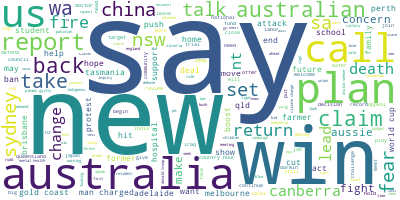

In [59]:
#Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(newsfile['headline_text'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=5, contour_color='grey')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

Now I want to make a list of the most words used across all the news headlines, this will give me some insight into the core vocabulary used in the source dataset. Stop words here will be gotten rid of to prevent any kind of mistakes in accordance to conjunctions, prepositions, etc.

In [60]:
# Defining the helper functions
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    This will return a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vec_headlines = count_vectorizer.fit_transform(text_data.values)
    vec_total = np.sum(vec_headlines, axis=0)
    word_indices = np.flip(np.argsort(vec_total)[0,:], 1)
    word_values = np.flip(np.sort(vec_total)[0,:],1)
    
    word_vec = np.zeros((n_top_words, vec_headlines.shape[1]))
    for i in range(n_top_words):
        word_vec[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vec)]

    return (words, word_values[0,:n_top_words].tolist()[0])

count_vectorizer = CountVectorizer(stop_words='english')
words, word_values = get_top_n_words(n_top_words=15,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=newsfile2)

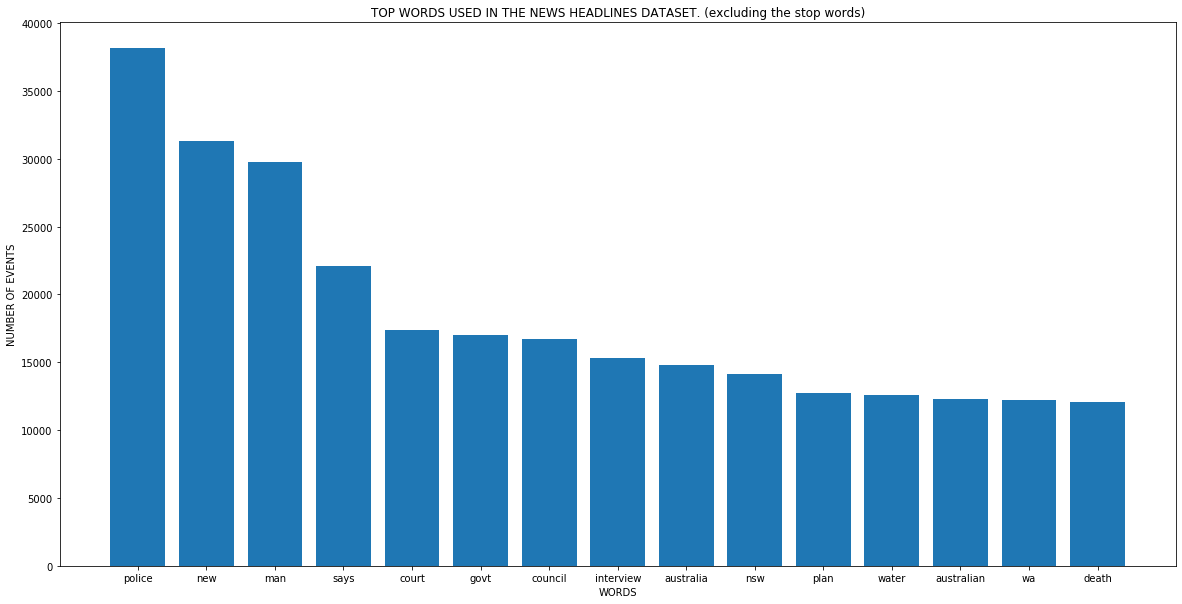

In [81]:
fig, ax = plt.subplots(figsize=(20,10))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='horizontal');
ax.set_title('TOP WORDS USED IN THE NEWS HEADLINES DATASET. (excluding the stop words)');
ax.set_xlabel('WORDS');
ax.set_ylabel('NUMBER OF EVENTS');
plt.show()

I now want to generate a histogram to see the lengths of headlines words, and use part-of-speech tagging to understand the types of words used across the corpus. This requires me to first convert all headline strings to TextBlobs and calling the 'pos_tags' method on each, yielding a list of tagged words for each headline. A complete list of such word tags is available here.

In [62]:
headlines_tag = [TextBlob(newsfile2[i]).pos_tags for i in range(newsfile2.shape[0])]

In [82]:
headlines_tag_df = pd.DataFrame({'tags': headlines_tag})

word_counts = [] 
pos_counts =  {}

for headline in headlines_tag_df[u'tags']:
    word_counts.append(len(headline))
    for tag in headline:
        if tag[1] in pos_counts:
            pos_counts[tag[1]] += 1
        else:
            pos_counts[tag[1]] = 1
            
print('THE TOTAL NUMBER OF WORDS: ', np.sum(word_counts))
print('THE MEAN OF TOTAL WORDS PER HEADLINE: ', np.mean(word_counts))

THE TOTAL NUMBER OF WORDS:  7706427
THE MEAN OF TOTAL WORDS PER HEADLINE:  6.497731906261119


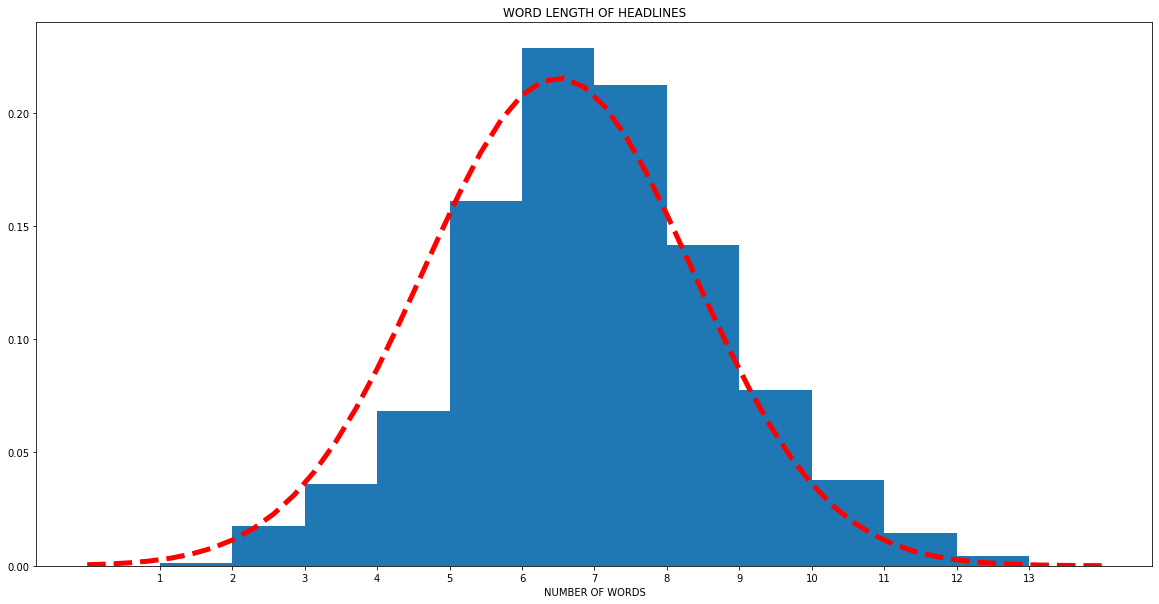

In [83]:
y = stats.norm.pdf(np.linspace(0,14,50), np.mean(word_counts), np.std(word_counts))

fig, ax = plt.subplots(figsize=(20,10))
ax.hist(word_counts, bins=range(1,14), density=True);
ax.plot(np.linspace(0,14,50), y, 'r--', linewidth=5);
ax.set_title('WORD LENGTH OF HEADLINES');
ax.set_xticks(range(1,14));
ax.set_xlabel('NUMBER OF WORDS');
plt.show()

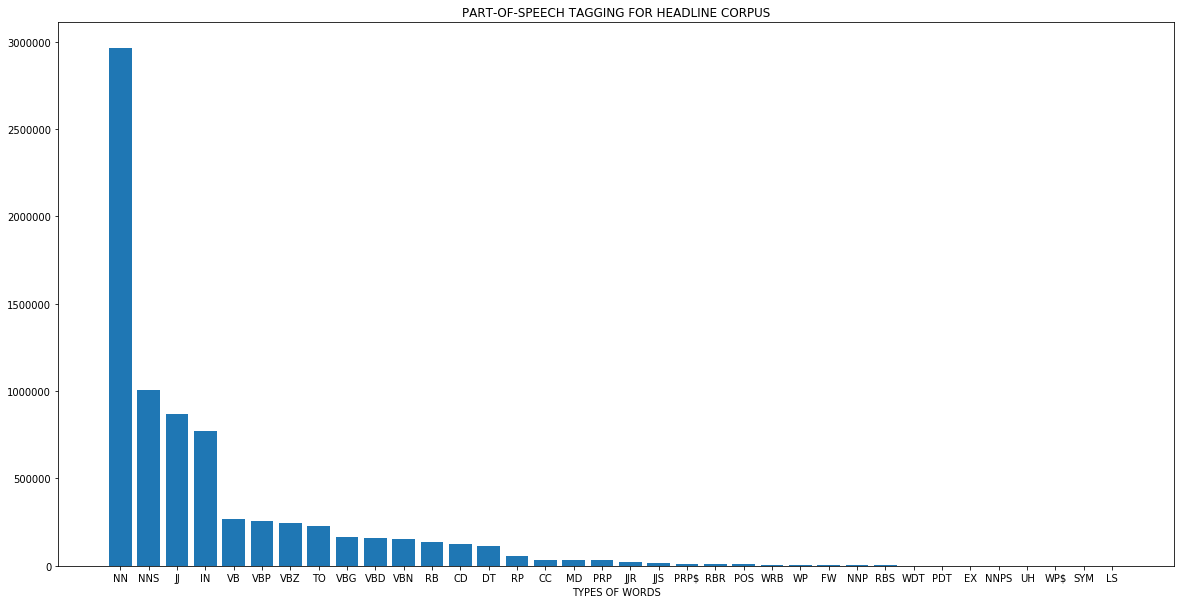

In [84]:
pos_sorted_types = sorted(pos_counts, key=pos_counts.__getitem__, reverse=True)
pos_sorted_counts = sorted(pos_counts.values(), reverse=True)

fig, ax = plt.subplots(figsize=(20,10))
ax.bar(range(len(pos_counts)), pos_sorted_counts);
ax.set_xticks(range(len(pos_counts)));
ax.set_xticklabels(pos_sorted_types);
ax.set_title('PART-OF-SPEECH TAGGING FOR HEADLINE CORPUS');
ax.set_xlabel('TYPES OF WORDS');

The number of headlines published per year, per month and per day can give a better insight into the sample density. I will plot this to show that.

/Users/qab/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


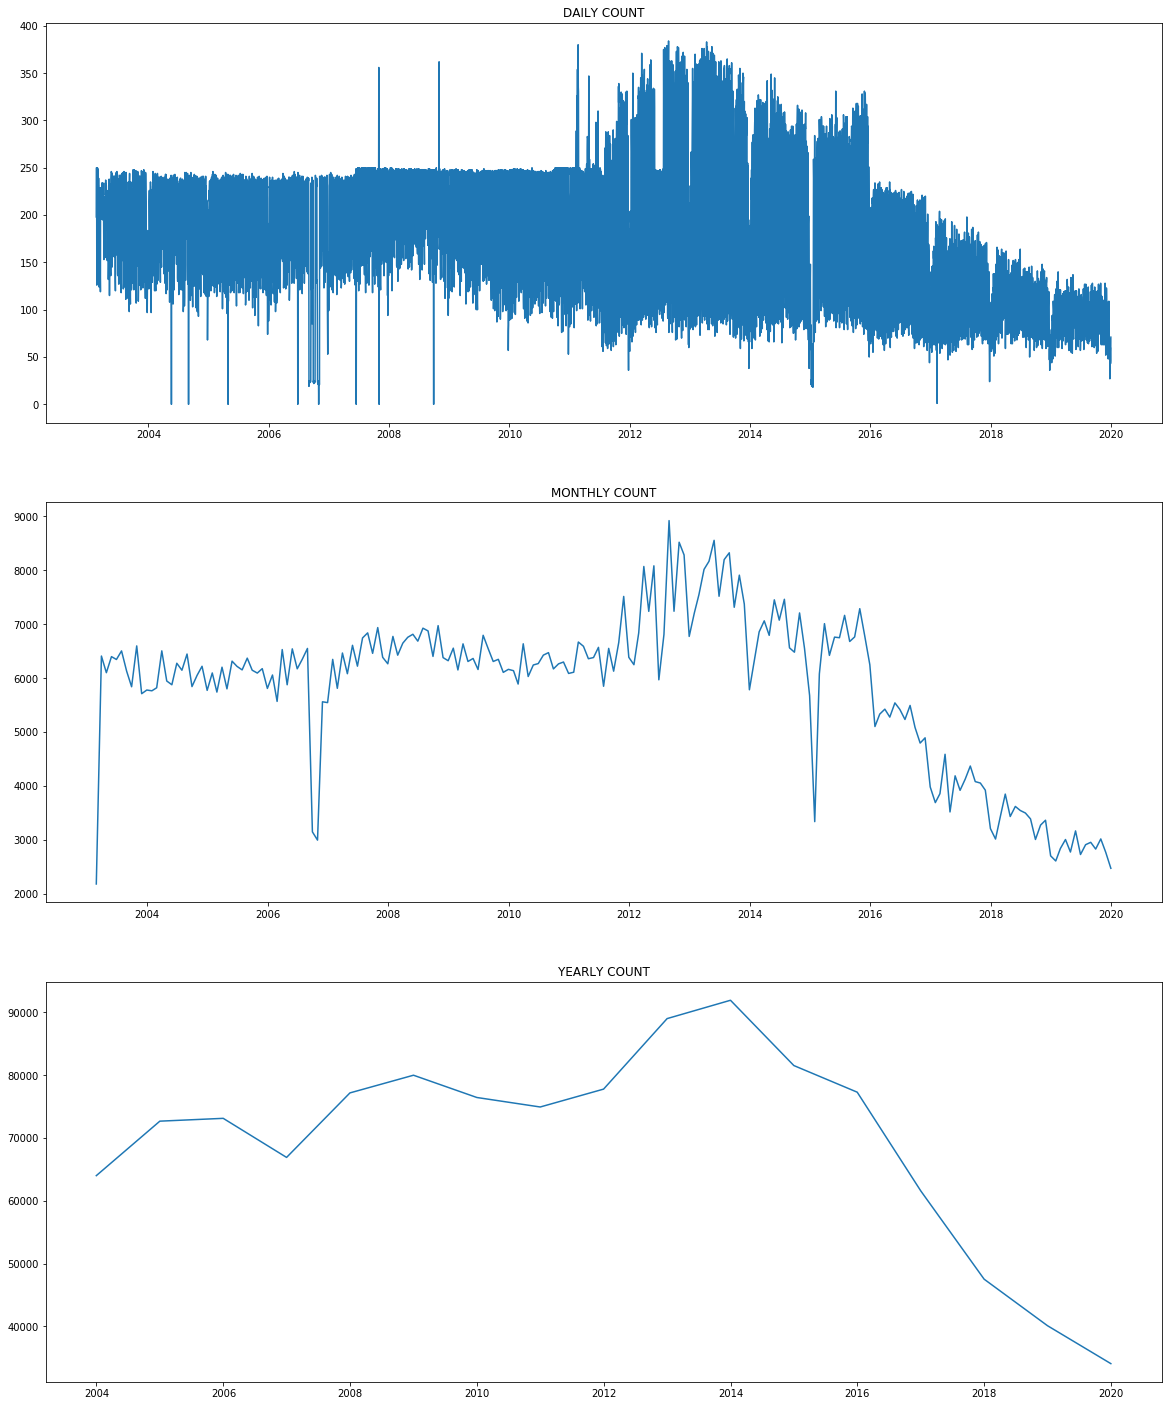

In [85]:
m_counts = newsfile2.resample('M').count()
y_counts = newsfile2.resample('A').count()
d_counts = newsfile2.resample('D').count()

fig, ax = plt.subplots(3, figsize=(20,25))
ax[0].plot(d_counts);
ax[0].set_title('DAILY COUNT');
ax[1].plot(m_counts);
ax[1].set_title('MONTHLY COUNT');
ax[2].plot(y_counts);
ax[2].set_title('YEARLY COUNT');
plt.show()

# TOPIC MODELLING

By applying a clustering algorithm to the headlines corpus, I can analyse the topic focus of ABC News, as well as how it has evolved through time. To do so, we first experiment with a small subsample of the dataset in order to determine which of the two potential clustering algorithms is most appropriate – once this has been ascertained, we then scale up to a larger portion of the available data.

## Preprocessing

The only preprocessing step required in this case is feature construction, where we take the sample of text headlines and represent them in some tractable feature space. In practice, this simply means converting each string to a numerical vector. This can be done using the CountVectorizer object from SKLearn, which yields an  n×K  document-term matrix where  K  is the number of distinct words across the  n  headlines in our sample (less stop words and with a limit of max_features).

In [86]:
small_count_vectorizer = CountVectorizer(stop_words='english', max_features=40000)
small_text_sample = newsfile2.sample(n=10000, random_state=0).values

print('HEADLINE BEFORE VECTORIZATION: {}'.format(small_text_sample[123]))

small_document_term_matrix = small_count_vectorizer.fit_transform(small_text_sample)

print('HEADLINE AFTER VECTORIZATION: \n{}'.format(small_document_term_matrix[123]))

HEADLINE BEFORE VECTORIZATION: mount isa kids urged to have lead level checks
HEADLINE AFTER VECTORIZATION: 
  (0, 6449)	1
  (0, 6218)	1
  (0, 7422)	1
  (0, 5933)	1
  (0, 11884)	1
  (0, 6532)	1
  (0, 2236)	1


Thus we have our (very high-rank and sparse) training data, small_document_term_matrix, and can now actually implement a clustering algorithm. Our choice will be either Latent Semantic Analysis or Latent Dirichilet Allocation. Both will take our document-term matrix as input and yield an  n×N  topic matrix as output, where  N  is the number of topic categories (which we supply as a parameter). For the moment, we shall take this to be 15.

In [102]:
num_topics = 15

# LATENT SEMANTIC ANALYSIS

Let's start by experimenting with LSA. This is effectively just a truncated singular value decomposition of a (very high-rank and sparse) document-term matrix, with only the  r = num_topics largest singular values preserved.

In [89]:
lsa_model = TruncatedSVD(n_components=num_topics)
lsa_topic_matrix = lsa_model.fit_transform(small_document_term_matrix)

Taking the  argmax  of each headline in this topic matrix will give the predicted topics of each headline in the sample. We can then sort these into counts of each topic.

In [90]:
# Defining the helper functions
def get_keys(topic_matrix):
    '''
    This returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    This returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

In [91]:
lsa_keys = get_keys(lsa_topic_matrix)
lsa_categories, lsa_counts = keys_to_counts(lsa_keys)

However, these topic categories are in and of themselves a little meaningless. In order to better characterise them, it will be helpful to find the most frequent words in each.

In [92]:
# Defining the helper functions
def get_top_n_words(n, keys, document_term_matrix, count_vectorizer):
    '''
    This returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(num_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

In [93]:
top_n_words_lsa = get_top_n_words(15, lsa_keys, small_document_term_matrix, small_count_vectorizer)

for i in range(len(top_n_words_lsa)):
    print("Topic {}: ".format(i+1), top_n_words_lsa[i])

Topic 1:  police missing search attack assault drug man investigate house release probe officer body car claims
Topic 2:  new deal laws mayor zealand set coach war chief anti year looks campaign announces signs
Topic 3:  man sydney charged murder arrested brisbane jailed accused melbourne bail years child court darwin stabbing
Topic 4:  says mp union labor election state iraq big trump key expert attacks work industry iran
Topic 5:  council calls plans funding group urged community action centre backs set public funds inquiry land
Topic 6:  nsw country claims hour tas drought home nt farm push help government rain change sale
Topic 7:  govt urged nt plan act denies local defends wa vic fund asked accused help water
Topic 8:  crash car killed woman dead driver injured road wins trial baby fatal kills children hit
Topic 9:  court accused face told faces charges case loses bid killer alleged death bail rape hearing
Topic 10:  qld north rural coast outback korea mid join coal west western 

Thus we have converted our initial small sample of headlines into a list of predicted topic categories, where each category is characterised by its most frequent words. The relative magnitudes of each of these categories can then be easily visualised though use of a bar chart.

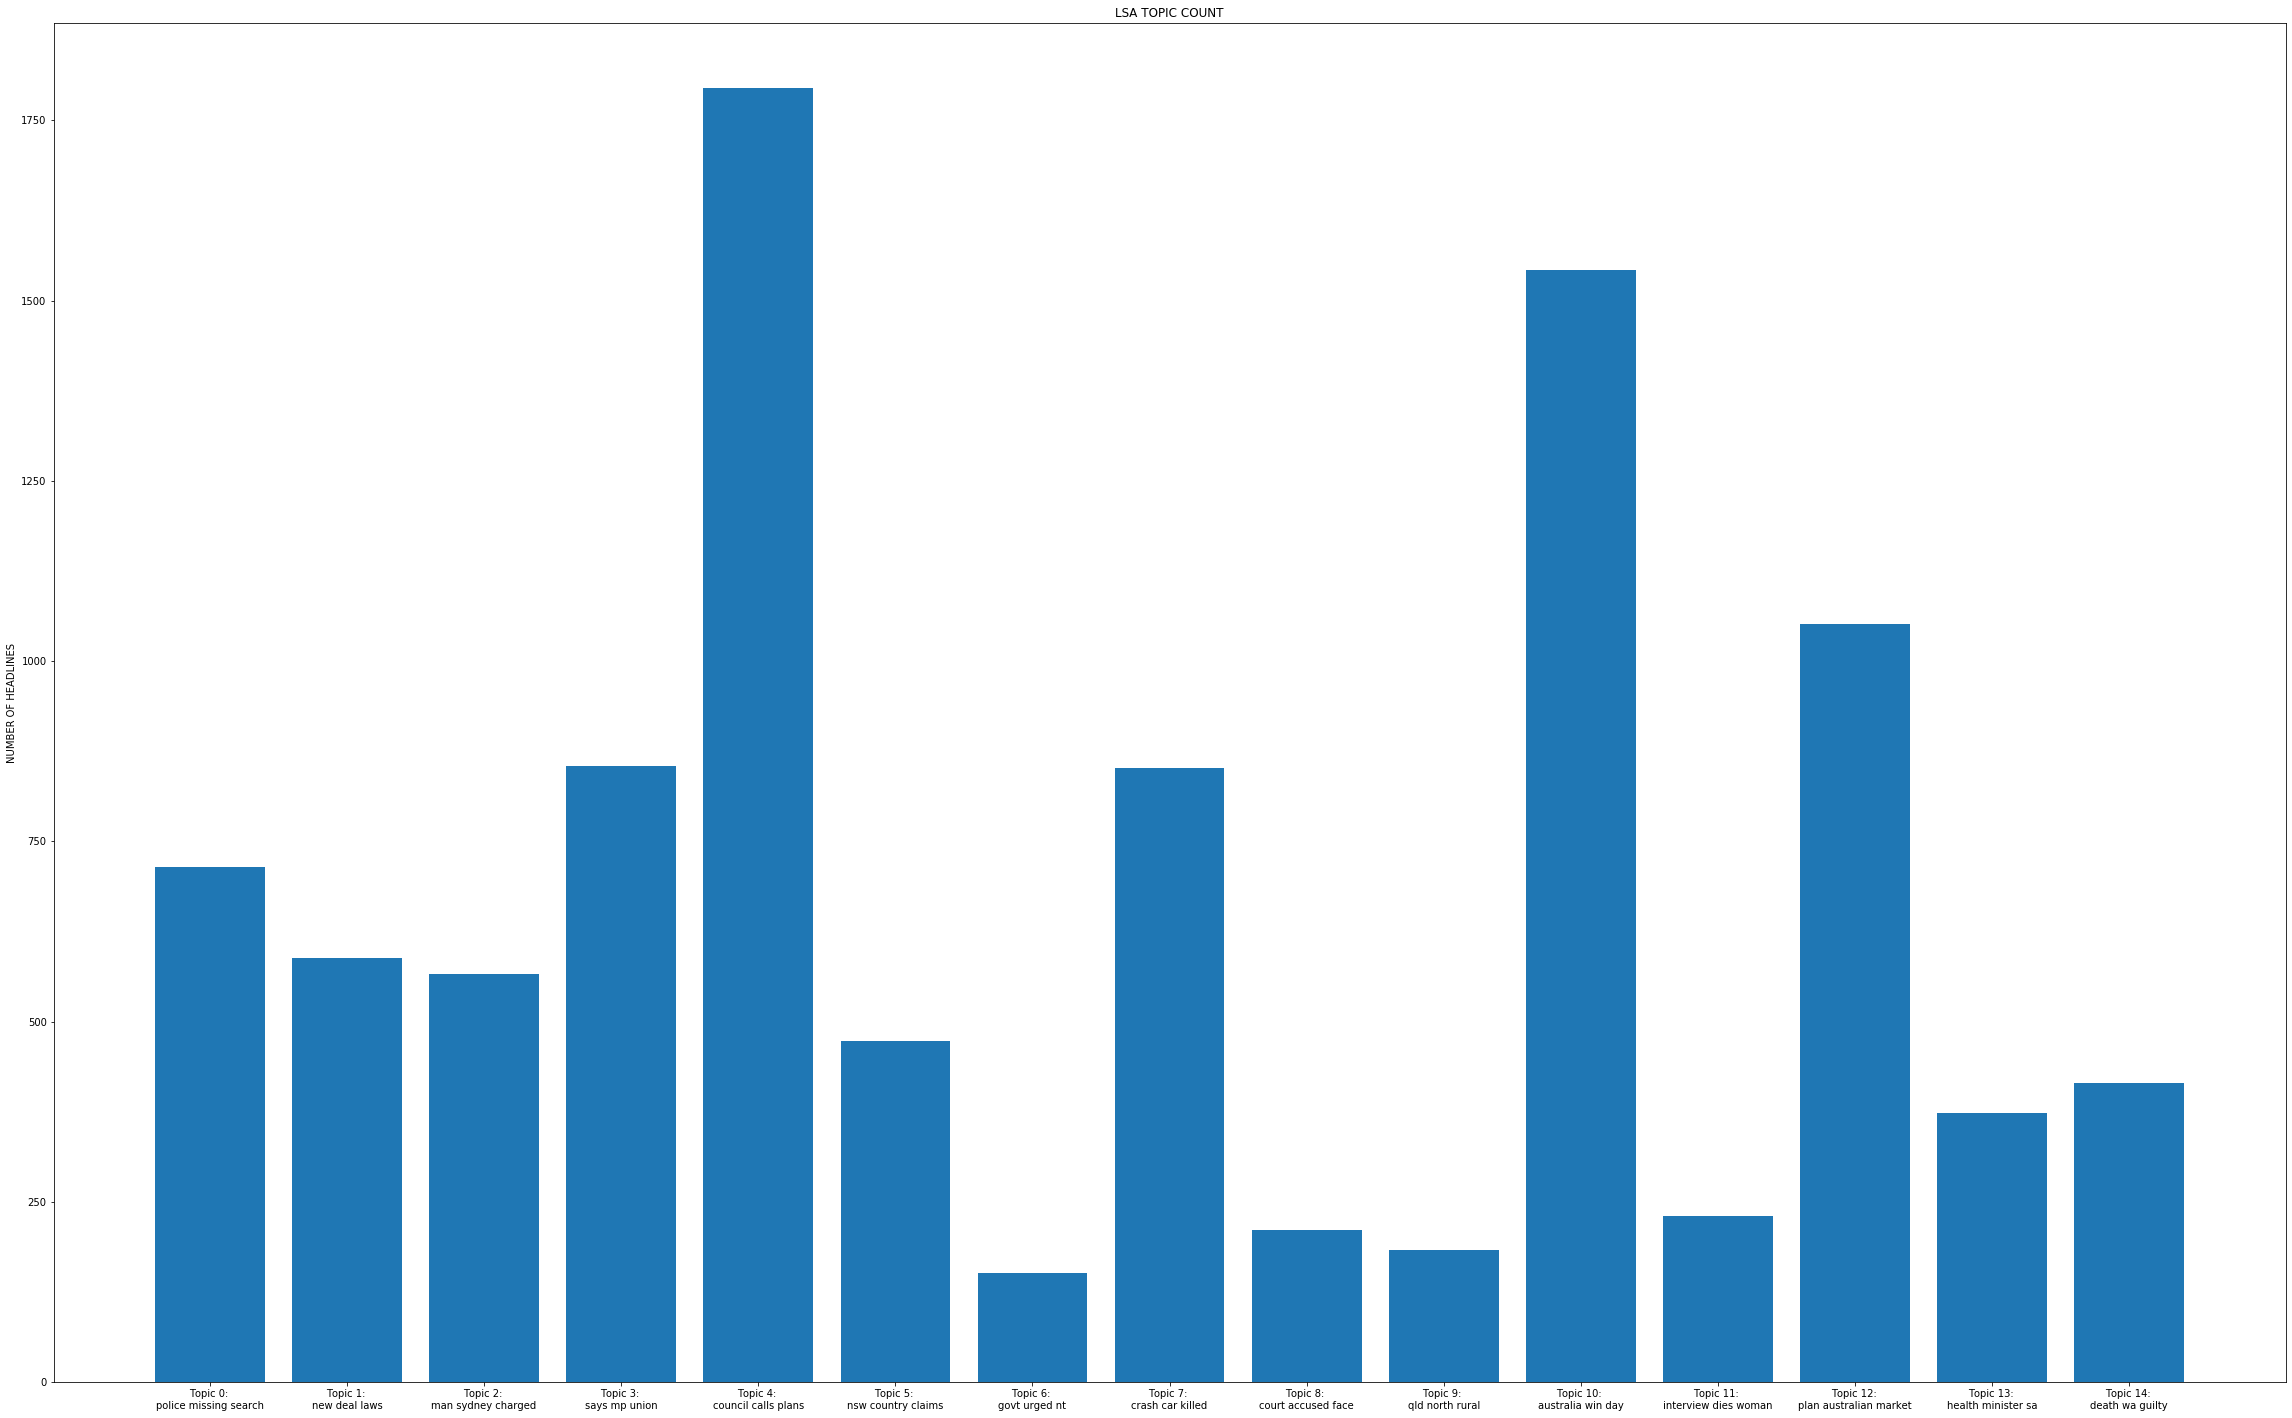

In [101]:
top_3_words = get_top_n_words(3, lsa_keys, small_document_term_matrix, small_count_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lsa_categories]

fig, ax = plt.subplots(figsize=(40,25))
ax.bar(lsa_categories, lsa_counts);
ax.set_xticks(lsa_categories);
ax.set_xticklabels(labels);
ax.set_ylabel('NUMBER OF HEADLINES');
ax.set_title('LSA TOPIC COUNT');
plt.show()

However, this does not provide a great point of comparison with other clustering algorithms. In order to properly contrast LSA with LDA we instead use a dimensionality-reduction technique called  t -SNE, which will also serve to better illuminate the success of the clustering process.

In [103]:
tsne_lsa_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lsa_vectors = tsne_lsa_model.fit_transform(lsa_topic_matrix)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.013s...
[t-SNE] Computed neighbors for 10000 samples in 2.042s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.004547
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.099358
[t-SNE] KL divergence after 2000 iterations: 1.197559


Now that we have reduced these n_topics-dimensional vectors to two-dimensional representations, we can then plot the clusters using Bokeh. Before doing so however, it will be useful to derive the centroid location of each topic, so as to better contextualise our visualisation.

In [104]:
# Defining the helper functions
def get_mean_topic_vectors(keys, two_dim_vectors):
    '''
    This returns a list of centroid vectors from each predicted topic category
    '''
    mean_topic_vectors = []
    for t in range(num_topics):
        articles_in_that_topic = []
        for i in range(len(keys)):
            if keys[i] == t:
                articles_in_that_topic.append(two_dim_vectors[i])    
        
        articles_in_that_topic = np.vstack(articles_in_that_topic)
        mean_article_in_that_topic = np.mean(articles_in_that_topic, axis=0)
        mean_topic_vectors.append(mean_article_in_that_topic)
    return mean_topic_vectors

In [105]:
colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5" ])
colormap = colormap[:num_topics]

All that remains is to plot the clustered headlines. Also included are the top three words in each cluster, which are placed at the centroid for that topic.

In [106]:
top_3_words_lsa = get_top_n_words(3, lsa_keys, small_document_term_matrix, small_count_vectorizer)
lsa_mean_topic_vectors = get_mean_topic_vectors(lsa_keys, tsne_lsa_vectors)

plot = figure(title="t-SNE CLUSTERING OF {} LSA TOPICS".format(num_topics), plot_width=900, plot_height=1000)
plot.scatter(x=tsne_lsa_vectors[:,0], y=tsne_lsa_vectors[:,1], color=colormap[lsa_keys])

for t in range(num_topics):
    label = Label(x=lsa_mean_topic_vectors[t][0], y=lsa_mean_topic_vectors[t][1], 
                  text=top_3_words_lsa[t], text_color=colormap[t])
    plot.add_layout(label)
    
show(plot)

Evidently, this is a bit a of a failed result. We have failed to reach any great degree of separation across the topic categories, and it is difficult to tell whether this can be attributed to the LSA decomposition or instead the  t -SNE dimensionality reduction process. Let's move forward and try another clustering technique.

# LATENT DIRICHILET ALLOCATION

We now repeat this process using LDA instead of LSA. LDA is instead a generative probabilistic process, designed with the specific goal of uncovering latent topic structure in text corpora.

In [107]:
lda_model = LatentDirichletAllocation(n_components=num_topics, learning_method='online', 
                                          random_state=0, verbose=0)
lda_topic_matrix = lda_model.fit_transform(small_document_term_matrix)

Once again, we take the  argmax  of each entry in the topic matrix to obtain the predicted topic category for each headline. These topic categories can then be characterised by their most frequent words.

In [108]:
lda_keys = get_keys(lda_topic_matrix)
lda_categories, lda_counts = keys_to_counts(lda_keys)

In [109]:
top_n_words_lda = get_top_n_words(15, lda_keys, small_document_term_matrix, small_count_vectorizer)

for i in range(len(top_n_words_lda)):
    print("Topic {}: ".format(i+1), top_n_words_lda[i])

Topic 1:  election rural queensland change climate city federal media opposition local leader party new impact political
Topic 2:  new win search wa big missing final laws backs continues farm dead lead grand make
Topic 3:  year attack minister housing pm car police rates cattle high long new david cancer old
Topic 4:  man qld rise police family jail hold court hobart outback economic death stabbed stars schools
Topic 5:  murder charged child sex man trial brisbane baby abuse war rain says train police parliament
Topic 6:  home north south accused bail ban power case korea national appeal funds farmers new rate
Topic 7:  health school urged house mayor future regional blaze police england councils rejects new investigate job
Topic 8:  govt sa woman plans concerns union weather land rules bid rudd life indonesia target education
Topic 9:  court plan death council action face man indigenous told asylum adelaide takes return park wants
Topic 10:  says nsw coast water calls gold group hosp

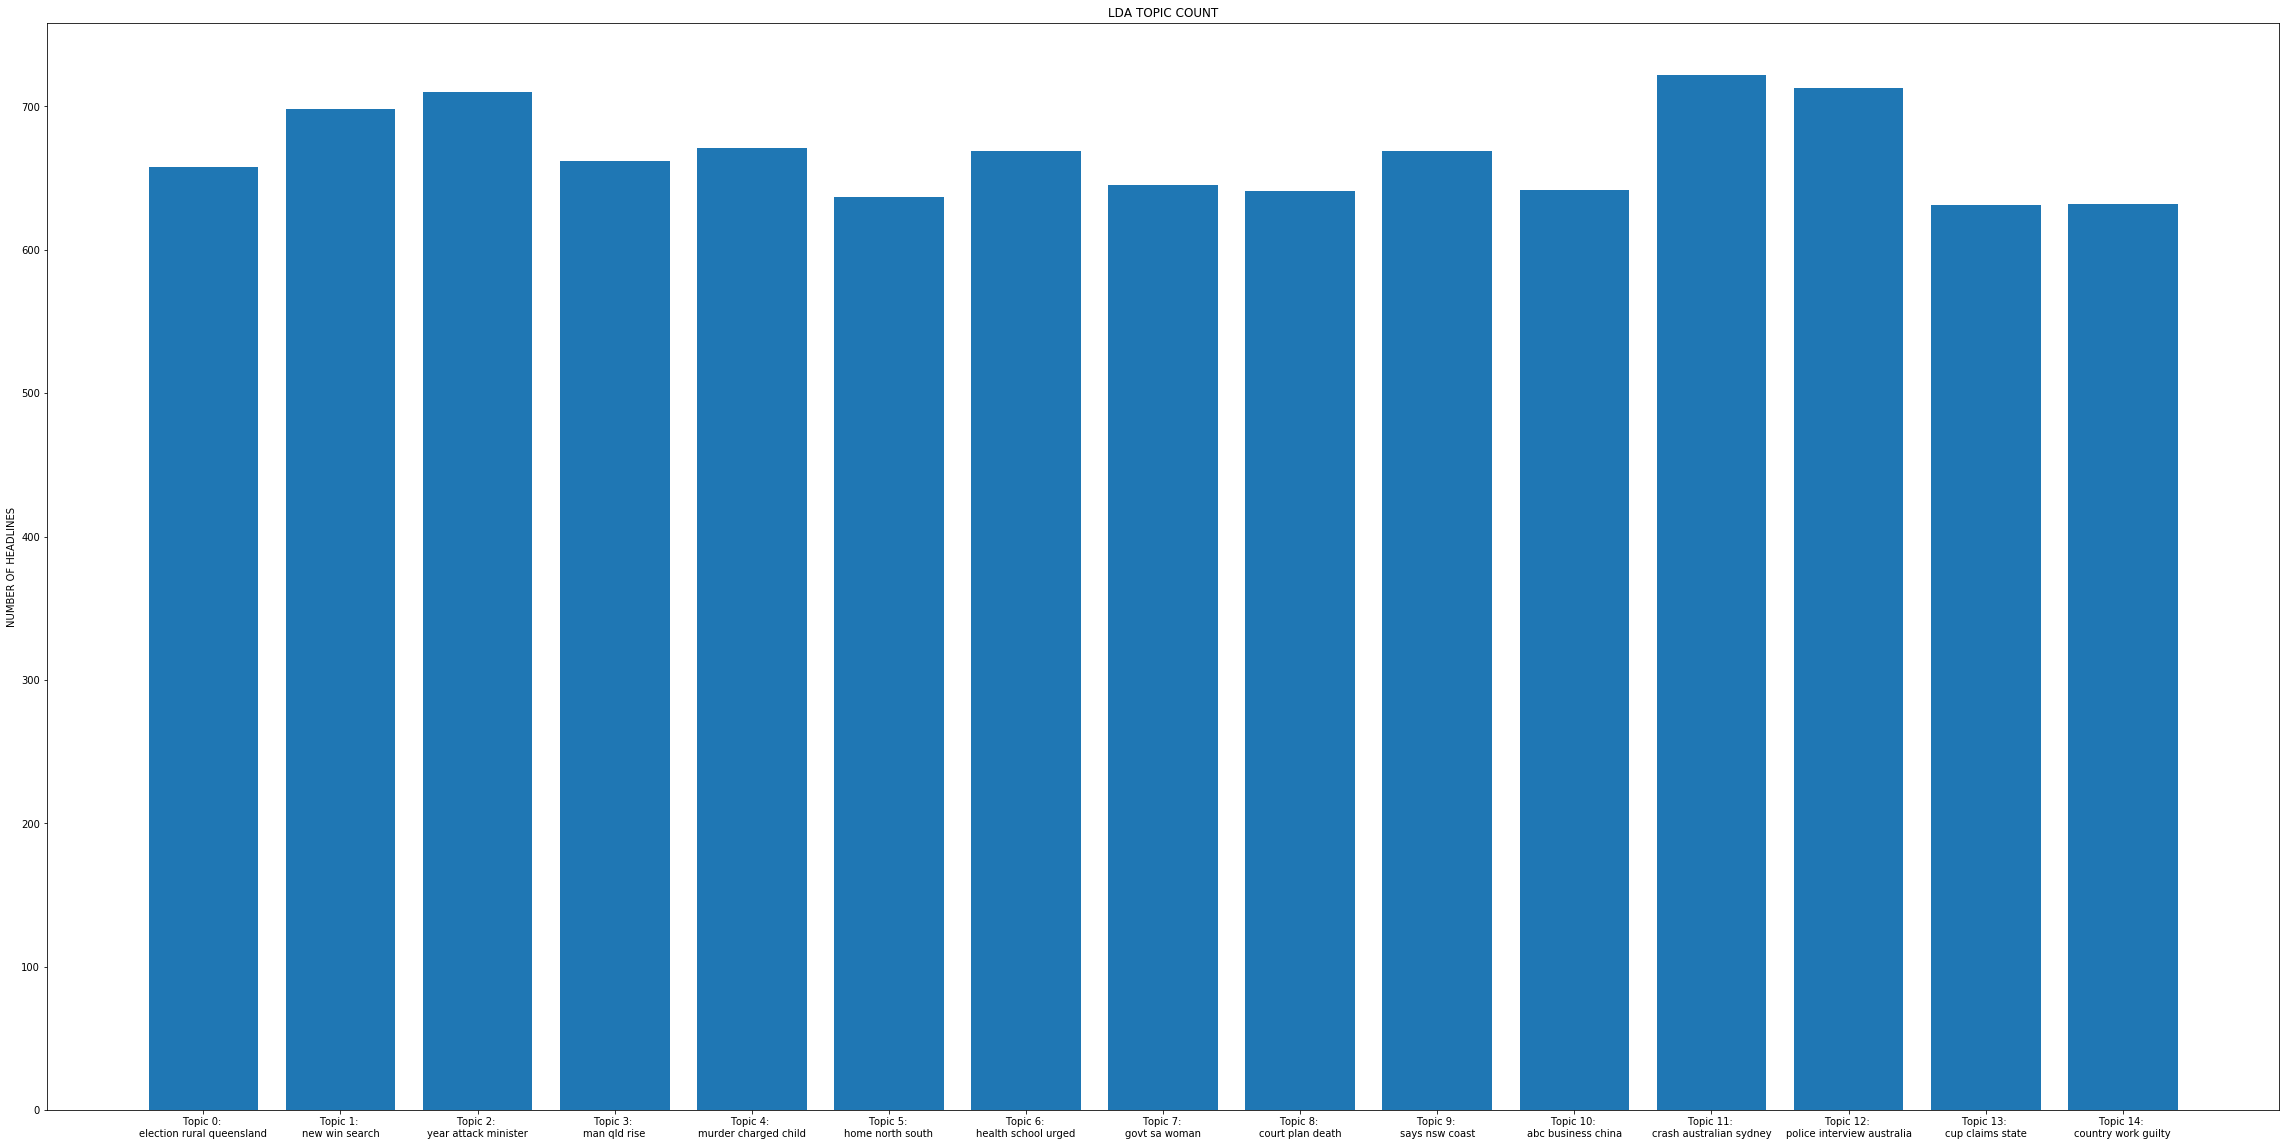

In [111]:
top_3_words = get_top_n_words(3, lda_keys, small_document_term_matrix, small_count_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lda_categories]

fig, ax = plt.subplots(figsize=(40,20))
ax.bar(lda_categories, lda_counts);
ax.set_xticks(lda_categories);
ax.set_xticklabels(labels);
ax.set_title('LDA TOPIC COUNT');
ax.set_ylabel('NUMBER OF HEADLINES');

However, in order to properly compare LDA with LSA, we again take this topic matrix and project it into two dimensions with  t-SNE.

In [112]:
tsne_lda_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lda_vectors = tsne_lda_model.fit_transform(lda_topic_matrix)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.006s...
[t-SNE] Computed neighbors for 10000 samples in 2.664s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.109877
[t-SNE] KL divergence after 250 iterations with early exaggeration: 87.727562
[t-SNE] KL divergence after 2000 iterations: 1.830347


In [113]:
top_3_words_lda = get_top_n_words(3, lda_keys, small_document_term_matrix, small_count_vectorizer)
lda_mean_topic_vectors = get_mean_topic_vectors(lda_keys, tsne_lda_vectors)

plot = figure(title="t-SNE CLUSTERING OF {} LDA TOPICS".format(num_topics), plot_width=900, plot_height=900)
plot.scatter(x=tsne_lda_vectors[:,0], y=tsne_lda_vectors[:,1], color=colormap[lda_keys])

for t in range(num_topics):
    label = Label(x=lda_mean_topic_vectors[t][0], y=lda_mean_topic_vectors[t][1], 
                  text=top_3_words_lda[t], text_color=colormap[t])
    plot.add_layout(label)

show(plot)

This is a much better result! Controlling for  t -SNE, it would seem that LDA has had much more succcess than LSA in separating out the topic categories. For this reason, LDA appears the more appropriate algorithm when we scale up the clustering process in the next section.

# SCALING UP

Now that we have found an effective clustering algorithm, we can scale it up. We still have to work with a subsample, as it is infeasible to train an LDA model one million observations, but we can significantly increase our scope to  300,000  headlines.

In [114]:
big_sample_size = 300000 

big_count_vectorizer = CountVectorizer(stop_words='english', max_features=40000)
big_text_sample = newsfile2.sample(n=big_sample_size, random_state=0).values
big_document_term_matrix = big_count_vectorizer.fit_transform(big_text_sample)

big_lda_model = LatentDirichletAllocation(n_components=num_topics, learning_method='online')
big_lda_model.fit(big_document_term_matrix);

We thus have our big topic model. The next step is to pass the entire dataset of one million headlines through this model, and sort by years. This will allow us to develop a table of topic counts per year.

In [115]:
y_data = []
for i in range(2003,2019+1):
    y_data.append(newsfile2['{}'.format(i)].values)

y_topic_matrices = []
for year in y_data:
    document_term_matrix = big_count_vectorizer.transform(year)
    topic_matrix = big_lda_model.transform(document_term_matrix)
    y_topic_matrices.append(topic_matrix)

y_keys = []
for topic_matrix in y_topic_matrices:
    y_keys.append(get_keys(topic_matrix))
    
y_counts = []
for keys in y_keys:
    categories, counts = keys_to_counts(keys)
    y_counts.append(counts)

y_topic_counts = pd.DataFrame(np.array(y_counts), index=range(2003,2019+1))
y_topic_counts.columns = ['TOPIC {}'.format(i+1) for i in range(num_topics)]

print(y_topic_counts)

      TOPIC 1  TOPIC 2  TOPIC 3  TOPIC 4  TOPIC 5  TOPIC 6  TOPIC 7  TOPIC 8  \
2003     4074     4439     4310     4323     4099     4560     3536     4035   
2004     5307     5011     4759     5085     4670     4477     5393     4587   
2005     5427     4635     5141     4784     4600     5011     4807     5396   
2006     5468     4148     4315     4478     4618     4073     3866     4494   
2007     6190     5119     5458     5871     4442     4486     5489     5210   
2008     6150     4702     5445     4937     4965     5460     5974     5065   
2009     4600     5043     5040     5258     5278     5243     4871     5761   
2010     4810     4613     4936     5030     5012     4846     4753     4991   
2011     4984     4819     5282     5176     4435     5500     5293     5673   
2012     7204     5781     5802     5889     5833     5466     5578     5775   
2013     6471     6552     6385     5599     6076     5302     6200     6318   
2014     4681     4784     6750     4660

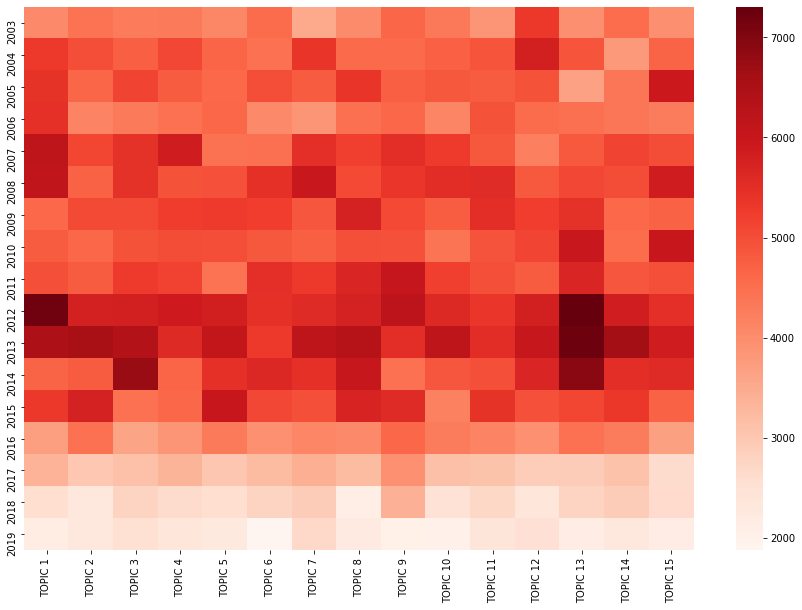

In [121]:
fig, ax = plt.subplots(figsize = (15,10))
sb.heatmap(y_topic_counts, cmap = 'Reds', ax = ax);
plt.show()

# MEANINGFUL RANDOM HEADLINES BY MARKOV CHAIN

Natural Language Generation is a very important area to be explored in our time. It forms the basis of how a bot would communicate with - not like how literates write books but like how we talk. In this Kernel, I'd like to show you a very simple but powerful Python module that does a similar exercise in (literally) a couple of lines of code.

Module: Markovify

The Py module we use here is markovify.

Descrption of Markovify:

Markovify is a simple, extensible Markov chain generator. Right now, its main use is for building Markov models of large corpora of text, and generating random sentences from that. But, in theory, it could be used for other applications.

Markov chains, named after Andrey Markov, are mathematical systems that hop from one "state" (a situation or set of values) to another. For example, if you made a Markov chain model of a baby's behavior, you might include "playing," "eating", "sleeping," and "crying" as states, which together with other behaviors could form a 'state space': a list of all possible states. In addition, on top of the state space, a Markov chain tells you the probabilitiy of hopping, or "transitioning," from one state to any other state---e.g., the chance that a baby currently playing will fall asleep in the next five minutes without crying first. Read more about how Markov Chain works in this interactive article by Victor Powell

In [122]:
import markovify #Markov Chain Generator

In [123]:
newsfile2.head(10)

publish_date
2003-02-19    aba decides against community broadcasting lic...
2003-02-19       act fire witnesses must be aware of defamation
2003-02-19       a g calls for infrastructure protection summit
2003-02-19             air nz staff in aust strike for pay rise
2003-02-19        air nz strike to affect australian travellers
2003-02-19                    ambitious olsson wins triple jump
2003-02-19           antic delighted with record breaking barca
2003-02-19    aussie qualifier stosur wastes four memphis match
2003-02-19         aust addresses un security council over iraq
2003-02-19           australia is locked into war timetable opp
Name: headline_text, dtype: object

In [124]:
import random
newsfile.headline_text[random.sample(range(100), 10)]

publish_date
2003-02-19                irish man arrested over omagh bombing
2003-02-19       british combat troops arriving daily in kuwait
2003-02-19    code of conduct toughens organ donation regula...
2003-02-19             council welcomes ambulance levy decision
2003-02-19                 golf club feeling smoking ban impact
2003-02-19    aussie qualifier stosur wastes four memphis match
2003-02-19                   low demand forces air service cuts
2003-02-19       a g calls for infrastructure protection summit
2003-02-19      german court to give verdict on sept 11 accused
2003-02-19          kelly disgusted at alleged bp ethanol scare
Name: headline_text, dtype: object

In [125]:
text_model = markovify.NewlineText(newsfile.headline_text, state_size = 2)

In [126]:
for i in range(15):
    print(text_model.make_sentence())

farm day in the face of work australia
greens question gunns pulp mill panel
central west council unveils flood assistance for broken hill pair share in wa
uni revels in all australian captain ricky ponting talks exclusively to the world tour to look down on asteroid agency says live cattle soars
iemma calls for long term climate change deadlock
vandals sandwiched by new year in australia where its due stuart
for the season to hit speeders
sth african rugby chief on philippines government relocating water side
cold showers for kiwis encounter
asic relaxes rules on trumps plan for labor and greens
floods prompt focus on indigenous issues
dellacqua withdraws from exhibition match
roofs collapse as state funeral
un still concerned about mid west policeman named top swan
some luckier than others during


In [127]:
text_model1 = markovify.NewlineText(newsfile.headline_text, state_size = 3)
text_model2 = markovify.NewlineText(newsfile.headline_text, state_size = 4)

In [128]:
# Print three randomly-generated sentences using the built model
for i in range(10):
    print(text_model1.make_sentence())

national science strategy aims at improve youth wellbeing
mp vows to stay out of fijian affairs military chief
mentally ill man cleared of underage sex
princess diana inquest to be held friday
chief executive of the act budget affects where you live
None
None
sniffer dogs in schools kick up a storm in a teacup
cleric abu qatada walks free after child porn raid nets 70
indonesian military to assist in slipper case


In [129]:
# Print three randomly-generated sentences using the built model
for i in range(10):
    temp = text_model2.make_sentence()
    if temp is not None: #escpaing None with this if condition as higher state markov model has generated more Nones
        print(temp)

wall street stocks fall us china trade war deal optimism asx


In [130]:
text_model11 = markovify.NewlineText(newsfile.headline_text, state_size = 2)
text_model12 = markovify.NewlineText(newsfile.headline_text, state_size = 2)
model_combo = markovify.combine([ text_model11, text_model12 ], [ 1.5, 1 ])
# Print three randomly-generated sentences using the built model
for i in range(5):
    print(text_model11.make_sentence())

coe refuses to budge on smacking
russia plays down importance of counting iconic
daniher pleased with rankings progress
icpa praises behind the latest bronco injury concern for elephants
albany man gets jail time cut for australia seized in raid
